In [84]:
import numpy as np
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

In [85]:
def perform_gmm(xs, thetas):
    tol = 0.01 #stop condition
    max_iter = 100

    ll_old = 0
    for i in range(max_iter):
        ws_A = []
        ws_B = []

        vs_A = []
        vs_B = []

        ll_new = 0

        # E-step: calculate probability distributions over possible completions
        for x in xs:

            # multinomial (binomial) log likelihood
            ll_A = np.sum([x*np.log(thetas[0])])
            ll_B = np.sum([x*np.log(thetas[1])])

            # [EQN 1]
            denom = np.exp(ll_A) + np.exp(ll_B)
            w_A = np.exp(ll_A)/denom
            w_B = np.exp(ll_B)/denom

            ws_A.append(w_A)
            ws_B.append(w_B)

            # used for calculating theta
            vs_A.append(np.dot(w_A, x))
            vs_B.append(np.dot(w_B, x))

            # update complete log likelihood
            ll_new += w_A * ll_A + w_B * ll_B

        # M-step: update values for parameters given current distribution
        # [EQN 2]
        thetas[0] = np.sum(vs_A, 0)/np.sum(vs_A)
        thetas[1] = np.sum(vs_B, 0)/np.sum(vs_B)
        # print distribution of z for each x and current parameter estimate

        print ("Iteration: %d" % (i+1))
        print ("theta_A = %.2f, theta_B = %.2f, ll = %.2f" % (thetas[0,0], thetas[1,0], ll_new))

        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new

Example 1

In [99]:
xs = np.array([(5,5), (9,1), (8,2), (4,6), (7,3)])
thetas = np.array([[0.65, 0.50], [0.5, 0.5]])

perform_gmm(xs, thetas)

Iteration: 1
theta_A = 0.67, theta_B = 0.59, ll = -27.23
Iteration: 2
theta_A = 0.72, theta_B = 0.59, ll = -31.75
Iteration: 3
theta_A = 0.74, theta_B = 0.57, ll = -31.31
Iteration: 4
theta_A = 0.77, theta_B = 0.55, ll = -30.82
Iteration: 5
theta_A = 0.78, theta_B = 0.54, ll = -30.38
Iteration: 6
theta_A = 0.79, theta_B = 0.53, ll = -30.10
Iteration: 7
theta_A = 0.79, theta_B = 0.52, ll = -29.96
Iteration: 8
theta_A = 0.80, theta_B = 0.52, ll = -29.91
Iteration: 9
theta_A = 0.80, theta_B = 0.52, ll = -29.88
Iteration: 10
theta_A = 0.80, theta_B = 0.52, ll = -29.87


In [100]:
xs = np.array([(5,5), (9,1), (8,2), (4,6), (7,3)])
thetas = np.array([[0.80, 0.55], [0.5, 0.5]])

perform_gmm(xs, thetas)

Iteration: 1
theta_A = 0.66, theta_B = 0.54, ll = -18.11
Iteration: 2
theta_A = 0.73, theta_B = 0.57, ll = -31.67
Iteration: 3
theta_A = 0.76, theta_B = 0.56, ll = -30.95
Iteration: 4
theta_A = 0.78, theta_B = 0.54, ll = -30.48
Iteration: 5
theta_A = 0.79, theta_B = 0.53, ll = -30.15
Iteration: 6
theta_A = 0.79, theta_B = 0.52, ll = -29.98
Iteration: 7
theta_A = 0.80, theta_B = 0.52, ll = -29.91
Iteration: 8
theta_A = 0.80, theta_B = 0.52, ll = -29.89
Iteration: 9
theta_A = 0.80, theta_B = 0.52, ll = -29.88
Iteration: 10
theta_A = 0.80, theta_B = 0.52, ll = -29.87


Example 2

In [101]:
xs = np.array([(4,6), (6,4), (5,5), (5, 5), (6, 4)])
thetas = np.array([[0.60, 0.55], [0.5, 0.5]])

perform_gmm(xs, thetas)

Iteration: 1
theta_A = 0.52, theta_B = 0.52, ll = -29.01
Iteration: 2
theta_A = 0.52, theta_B = 0.52, ll = -34.62
Iteration: 3
theta_A = 0.52, theta_B = 0.52, ll = -34.62


In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import logsumexp
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt


def GMM_sklearn(x, weights=None, means=None, covariances=None):
    model = GaussianMixture(n_components=2,
                            covariance_type='full',
                            tol=0.01,
                            max_iter=1000,
                            weights_init=weights,
                            means_init=means,
                            precisions_init=covariances)
    model.fit(x)
    print("\nscikit learn:\n\tphi: %s\n\tmu_0: %s\n\tmu_1: %s\n\tsigma_0: %s\n\tsigma_1: %s"
               % (model.weights_[1], model.means_[0, :], model.means_[1, :], model.covariances_[0, :], model.covariances_[1, :]))
    return model.predict(x), model.predict_proba(x)[:,1]


def get_random_psd(n):
    x = np.random.normal(0, 1, size=(n, n))
    return np.dot(x, x.transpose())


def initialize_random_params():
    params = {'phi': np.random.uniform(0, 1),
              'mu0': np.random.normal(0, 1, size=(2,)),
              'mu1': np.random.normal(0, 1, size=(2,)),
              'sigma0': get_random_psd(2),
              'sigma1': get_random_psd(2)}
    return params


def learn_params(x_labeled, y_labeled):
    n = x_labeled.shape[0]
    phi = x_labeled[y_labeled == 1].shape[0] / n
    mu0 = np.sum(x_labeled[y_labeled == 0], axis=0) / x_labeled[y_labeled == 0].shape[0]
    mu1 = np.sum(x_labeled[y_labeled == 1], axis=0) / x_labeled[y_labeled == 1].shape[0]
    sigma0 = np.cov(x_labeled[y_labeled == 0].T, bias= True)
    sigma1 = np.cov(x_labeled[y_labeled == 1].T, bias=True)
    return {'phi': phi, 'mu0': mu0, 'mu1': mu1, 'sigma0': sigma0, 'sigma1': sigma1}


def e_step(x, params):
    np.log([stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
            stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(x)])
    log_p_y_x = np.log([1-params["phi"], params["phi"]])[np.newaxis, ...] + \
                np.log([stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
            stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(x)]).T
    log_p_y_x_norm = logsumexp(log_p_y_x, axis=1)
    return log_p_y_x_norm, np.exp(log_p_y_x - log_p_y_x_norm[..., np.newaxis])


def m_step(x, params):
    total_count = x.shape[0]
    _, heuristics = e_step(x, params)
    heuristic0 = heuristics[:, 0]
    heuristic1 = heuristics[:, 1]
    sum_heuristic1 = np.sum(heuristic1)
    sum_heuristic0 = np.sum(heuristic0)
    phi = (sum_heuristic1/total_count)
    mu0 = (heuristic0[..., np.newaxis].T.dot(x)/sum_heuristic0).flatten()
    mu1 = (heuristic1[..., np.newaxis].T.dot(x)/sum_heuristic1).flatten()
    diff0 = x - mu0
    sigma0 = diff0.T.dot(diff0 * heuristic0[..., np.newaxis]) / sum_heuristic0
    diff1 = x - mu1
    sigma1 = diff1.T.dot(diff1 * heuristic1[..., np.newaxis]) / sum_heuristic1
    params = {'phi': phi, 'mu0': mu0, 'mu1': mu1, 'sigma0': sigma0, 'sigma1': sigma1}
    return params


def get_avg_log_likelihood(x, params):
    loglikelihood, _ = e_step(x, params)
    return np.mean(loglikelihood)


def run_em(x, params):
    avg_loglikelihoods = []
    while True:
        avg_loglikelihood = get_avg_log_likelihood(x, params)
        avg_loglikelihoods.append(avg_loglikelihood)
        if len(avg_loglikelihoods) > 2 and abs(avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0.0001:
            break
        params = m_step(x_unlabeled, params)
    print("\tphi: %s\n\tmu_0: %s\n\tmu_1: %s\n\tsigma_0: %s\n\tsigma_1: %s"
               % (params['phi'], params['mu0'], params['mu1'], params['sigma0'], params['sigma1']))
    _, posterior = e_step(x_unlabeled, params)
    forecasts = np.argmax(posterior, axis=1)
    return forecasts, posterior, avg_loglikelihoods

unsupervised: 
	phi: 0.597876849583813
	mu_0: [-1.06779962 -1.06693409]
	mu_1: [0.96345585 0.98442329]
	sigma_0: [[0.34381833 0.28383432]
 [0.28383432 0.70949224]]
	sigma_1: [[0.74145462 0.15706812]
 [0.15706812 0.31610609]]
total steps:  32

semi-supervised: 
	phi: 0.5863498817945461
	mu_0: [-1.04546727 -1.02704636]
	mu_1: [0.98763329 0.99661118]
	sigma_0: [[0.36018609 0.30853357]
 [0.30853357 0.75384027]]
	sigma_1: [[0.7196797  0.1437903 ]
 [0.1437903  0.30853791]]
total steps:  4

scikit learn:
	phi: 0.59647894226803
	mu_0: [-1.06169376 -1.0563389 ]
	mu_1: [0.96408565 0.98206315]
	sigma_0: [[0.35027155 0.29629092]
 [0.29629092 0.73083581]]
	sigma_1: [[0.74510804 0.16156928]
 [0.16156928 0.32021029]]

99.4% of forecasts matched.


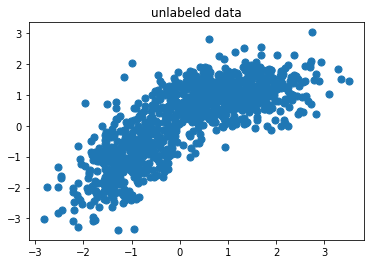

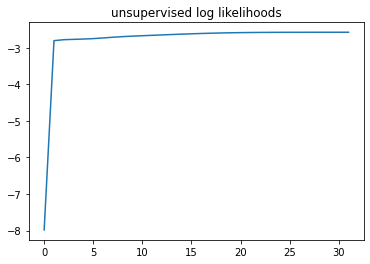

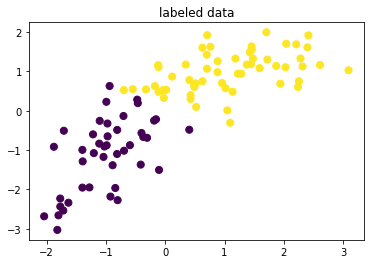

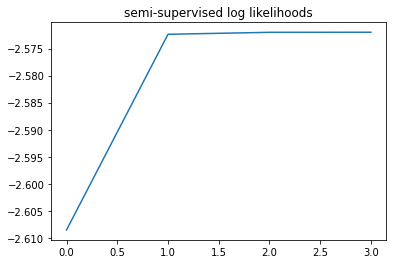

In [4]:
if __name__ == '__main__':
    data_unlabeled = pd.read_csv("../data/unlabeled.csv")
    #data_unlabeled = pd.read_csv("../data/labeled.csv")
    x_unlabeled = data_unlabeled[["x1", "x2"]].values
    
    plt.figure(0)
    plt.scatter(x_unlabeled[:, 0], x_unlabeled[:, 1], s=50);
    plt.title("unlabeled data")
        

    # Unsupervised learning
    print("unsupervised: ")
    random_params = initialize_random_params()
    unsupervised_forecastsforecasts, unsupervised_posterior, unsupervised_loglikelihoods = run_em(x_unlabeled, random_params)
    print("total steps: ", len(unsupervised_loglikelihoods))
    plt.figure(1)
    plt.plot(unsupervised_loglikelihoods)
    plt.title("unsupervised log likelihoods")
    plt.savefig("unsupervised.png")
    

    # Semi-supervised learning
    data_labeled = pd.read_csv("../data/labeled.csv")
    x_labeled = data_labeled[["x1", "x2"]].values
    y_labeled = data_labeled["y"].values
    
    plt.figure(2)
    plt.scatter(x_labeled[:, 0], x_labeled[:, 1], c=y_labeled, s=50, cmap='viridis')
    plt.title("labeled data")
    
    print("\nsemi-supervised: ")
    learned_params = learn_params(x_labeled, y_labeled)
    semisupervised_forecasts, semisupervised_posterior, semisupervised_loglikelihoods = run_em(x_unlabeled, learned_params)
    print("total steps: ", len(semisupervised_loglikelihoods))
    plt.figure(3)
    plt.plot(semisupervised_loglikelihoods)
    plt.title("semi-supervised log likelihoods")
    plt.savefig("semi-supervised.png")
    
    # Compare the forecats with Scikit-learn API
    learned_params = learn_params(x_labeled, y_labeled)
    weights = [1 - learned_params["phi"], learned_params["phi"]]
    means = [learned_params["mu0"], learned_params["mu1"]]
    covariances = [learned_params["sigma0"], learned_params["sigma1"]]
    sklearn_forecasts, posterior_sklearn = GMM_sklearn(x_unlabeled, weights, means, covariances)
    
    output_df = pd.DataFrame({'semisupervised_forecasts': semisupervised_forecasts,
                              'semisupervised_posterior': semisupervised_posterior[:, 1],
                              'sklearn_forecasts': sklearn_forecasts,
                              'posterior_sklearn': posterior_sklearn})

    print("\n%s%% of forecasts matched." % (output_df[output_df["semisupervised_forecasts"] == output_df["sklearn_forecasts"]].shape[0] /output_df.shape[0] * 100))

In [76]:
from datetime import datetime as dt
import numpy as np
from functools import reduce
np.random.seed(1024)

mu = np.array([1,2,6])
Sigma = np.array([[118,62,44], [62,49,17], [44,17,21]])

n = 400
X_truth = np.random.multivariate_normal(mu, Sigma,n)

In [77]:
def simulate_nan(X, nan_rate):
    X_complete = X.copy()
    nr,nc = X_complete.shape
    C = np.random.random(nr *nc).reshape(nr, nc) > nan_rate
    checker = np.where(sum(C.T) == 0)[0]
    if len(checker) == 0:
        X_complete[C == False] = np.nan
    else:
        for index in checker:
            reviving_components = np.random.choice(nc, int(np.ceil(nc*np.random.random())), replace = False)
            C[index,np.ix_(reviving_components)] = True
            X_complete[C == False] = np.nan
            result = {
                        'X': X_complete,
                        'C': C,
                        'nan_rate': nan_rate,
                        'nan_rate_actual': np.sum(C == False) / (nr *nc)}
            return result
        
result = simulate_nan(X_truth, nan_rate = .10)
X = result['X'].copy()
(sum((np.isnan(X) == False).T) == 0).any() == False
result['nan_rate_actual']

result

{'X': array([[-22.51504305, -11.21931542,  -0.31680441],
        [ -4.13801604,  -3.3813311 ,   3.97850866],
        [ -6.96117925,  -4.78845229,   1.21653198],
        ...,
        [ -8.53309711,  -4.17104975,   3.44262394],
        [  1.37769221,   7.18668   ,   5.10726117],
        [  7.61570646,   2.48587502,  11.05380599]]),
 'C': array([[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]]),
 'nan_rate': 0.1,
 'nan_rate_actual': 0.10166666666666667}

In [78]:
def impute_em(X, max_iter = 10000,eps = 1e-08):
    nr,nc = X.shape
    C = np.isnan(X) == False

    one_to_nc = np.arange(1,nc + 1, step = 1)
    M = one_to_nc * (C == False) -1
    O = one_to_nc * C -1

    Mu = np.nanmean(X, axis = 0)
    observed_rows = np.where(np.isnan(sum(X.T)) == False)[0]
    S = np.cov(X[observed_rows, ].T)
    if np.isnan(S).any():
        S = np.diag(np.nanvar(X,axis = 0))

    Mu_tilde, S_tilde = {}, {}
    X_tilde = X.copy()
    no_conv = True
    iteration = 0

    while no_conv and iteration < max_iter:
        for i in range(nr):
            S_tilde[i] = np.zeros(nc**2).reshape(nc,nc)
            if set(O[i, ]) != set(one_to_nc -1):
                M_i, O_i = M[i, ][M[i, ] != -1], O[i, ][O[i, ] != -1]
                S_MM = S[np.ix_(M_i, M_i)]
                S_MO = S[np.ix_(M_i, O_i)]
                S_OM = S_MO.T
                S_OO = S[np.ix_(O_i, O_i)]
                Mu_tilde[i] = Mu[np.ix_(M_i)] + S_MO @ np.linalg.inv(S_OO) @ (X_tilde[i, O_i] - Mu[np.ix_(O_i)])
                X_tilde[i, M_i] = Mu_tilde[i]
                S_MM_O = S_MM - S_MO @ np.linalg.inv(S_OO) @ S_OM
                S_tilde[i][np.ix_(M_i, M_i)] = S_MM_O
            Mu_new = np.mean(X_tilde, axis = 0)
            S_new = np.cov(X_tilde.T,bias = 1) +\
                reduce(np.add, S_tilde.values()) / nr
            no_conv =\
                np.linalg.norm(Mu- Mu_new) >= eps or\
                np.linalg.norm(S - S_new, ord = 1) >= eps
            Mu = Mu_new
            S = S_new
            iteration += 1
        result = {
                    'mu': Mu,
                    'Sigma': S,
                    'X_imputed': X_tilde,
                    'C': C,
                    'iteration': iteration
                    }
    return result

start = dt.now()
result_imputed = impute_em(X)
end = dt.now()

print(result_imputed['mu'])
result_imputed['Sigma']


[nan nan nan]


array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])

In [79]:
def impute_em(X, max_iter = 3000, eps = 1e-08):
    '''(np.array, int, number) -> {str: np.array or int}
    
    Precondition: max_iter >= 1 and eps > 0
    
    Return the dictionary with five keys where:
    - Key 'mu' stores the mean estimate of the imputed data.
    - Key 'Sigma' stores the variance estimate of the imputed data.
    - Key 'X_imputed' stores the imputed data that is mutated from X using 
      the EM algorithm.
    - Key 'C' stores the np.array that specifies the original missing entries
      of X.
    - Key 'iteration' stores the number of iteration used to compute
      'X_imputed' based on max_iter and eps specified.
    '''
    
    nr, nc = X.shape
    C = np.isnan(X) == False
    
    # Collect M_i and O_i's
    one_to_nc = np.arange(1, nc + 1, step = 1)
    M = one_to_nc * (C == False) - 1
    O = one_to_nc * C - 1
    
    # Generate Mu_0 and Sigma_0
    Mu = np.nanmean(X, axis = 0)
    observed_rows = np.where(np.isnan(sum(X.T)) == False)[0]
    S = np.cov(X[observed_rows, ].T)
    if np.isnan(S).any():
        S = np.diag(np.nanvar(X, axis = 0))
    
    # Start updating
    Mu_tilde, S_tilde = {}, {}
    X_tilde = X.copy()
    no_conv = True
    iteration = 0
    while no_conv and iteration < max_iter:
        for i in range(nr):
            S_tilde[i] = np.zeros(nc ** 2).reshape(nc, nc)
            if set(O[i, ]) != set(one_to_nc - 1): # missing component exists
                M_i, O_i = M[i, ][M[i, ] != -1], O[i, ][O[i, ] != -1]
                S_MM = S[np.ix_(M_i, M_i)]
                S_MO = S[np.ix_(M_i, O_i)]
                S_OM = S_MO.T
                S_OO = S[np.ix_(O_i, O_i)]
                Mu_tilde[i] = Mu[np.ix_(M_i)] +\
                    S_MO @ np.linalg.inv(S_OO) @\
                    (X_tilde[i, O_i] - Mu[np.ix_(O_i)])
                X_tilde[i, M_i] = Mu_tilde[i]
                S_MM_O = S_MM - S_MO @ np.linalg.inv(S_OO) @ S_OM
                S_tilde[i][np.ix_(M_i, M_i)] = S_MM_O
        Mu_new = np.mean(X_tilde, axis = 0)
        S_new = np.cov(X_tilde.T, bias = 1) +\
            reduce(np.add, S_tilde.values()) / nr
        no_conv =\
            np.linalg.norm(Mu - Mu_new) >= eps or\
            np.linalg.norm(S - S_new, ord = 2) >= eps
        Mu = Mu_new
        S = S_new
        iteration += 1
    
    result = {
        'mu': Mu,
        'Sigma': S,
        'X_imputed': X_tilde,
        'C': C,
        'iteration': iteration
    }
    
    return result
start = dt.now()
result_imputed = impute_em(X)
end = dt.now()

print(result_imputed['mu'])
result_imputed['Sigma']


[1.65310237 1.92223237 6.38654956]


array([[117.47706143,  65.50711011,  43.03976256],
       [ 65.50711011,  52.66150823,  18.17934048],
       [ 43.03976256,  18.17934048,  20.24549545]])

In [81]:
X

array([[-22.51504305, -11.21931542,  -0.31680441],
       [ -4.13801604,  -3.3813311 ,   3.97850866],
       [ -6.96117925,  -4.78845229,   1.21653198],
       ...,
       [ -8.53309711,  -4.17104975,   3.44262394],
       [  1.37769221,   7.18668   ,   5.10726117],
       [  7.61570646,   2.48587502,  11.05380599]])

In [83]:
df = X - result_imputed['X_imputed']
df[df > 0]

array([], dtype=float64)